In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from six.moves import cPickle

/vol/optdcc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Import dataset
train, test = datasets.get_mnist()

In [4]:
def get_batch(batch_size):
    batch_indices = np.random.choice(range(len(train)), size=(batch_size,), replace=False)
    return np.array([np.reshape(train[k][0], newshape=(1,28,28)) for k in batch_indices])

In [5]:
def get_random_input(batch_size, n_hidden):
    return np.random.normal(0,1,size=(batch_size, n_hidden)).astype("float32")

In [6]:
def plot_generated_images(generator, n_images=5):
    # Generate Images
    z = get_random_input(n_hidden=generator.n_hidden, batch_size=n_images)
    images = generator(z).data
    
    #Plot Images
    f, axis = plt.subplots(1, n_images, sharey=True)
    for index, ax in enumerate(axis):
        ax.imshow(images[index,0,:,:])
    plt.title("Generated Images")

In [7]:
class Generator(chainer.Chain):
    def __init__(self, n_hidden, bottom_width=3, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(in_size=n_hidden, out_size=bottom_width*bottom_width*ch, initialW=w)

            self.dc1 = L.Deconvolution2D(in_channels=ch, out_channels=ch//2, ksize=2, stride=2, pad=1, initialW=w)
            self.dc2 = L.Deconvolution2D(in_channels=ch//2, out_channels=ch//4, ksize=2, stride=2, pad=1, initialW=w)
            self.dc3 = L.Deconvolution2D(in_channels=ch//4, out_channels=ch//8, ksize=2, stride=2, pad=1, initialW=w)
            self.dc4 = L.Deconvolution2D(in_channels=ch//8, out_channels=1, ksize=3, stride=3, pad=1, initialW=w)

            # self.bn0 = L.BatchNormalization(size=self.bottom_width*self.bottom_width*self.ch)
            self.bn1 = L.BatchNormalization(size=ch)
            self.bn2 = L.BatchNormalization(size=ch//2)
            self.bn3 = L.BatchNormalization(size=ch//4)
            self.bn4 = L.BatchNormalization(size=ch//8)

    def make_hidden(self, batchsize):
        return numpy.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(numpy.float32)

    def __call__(self, z):
        h = self.l0(z)
        h = F.reshape(h, (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(h))
        h = F.relu(self.bn2(self.dc1(h)))
        h = F.relu(self.bn3(self.dc2(h)))
        h = F.relu(self.bn4(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        # x = F.tanh(self.dc4(h))

        return x
    
class Discriminator(chainer.Chain):
    def __init__(self, bottom_width=3, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():

            self.c0 = L.Convolution2D(in_channels=1, out_channels=64, ksize=3, stride=3, pad=1, initialW=w)
            self.c1 = L.Convolution2D(in_channels=ch//8, out_channels=128, ksize=2, stride=2, pad=1, initialW=w)
            self.c2 = L.Convolution2D(in_channels=ch//4, out_channels=256, ksize=2, stride=2, pad=1, initialW=w)
            self.c3 = L.Convolution2D(in_channels=ch//2, out_channels=512, ksize=2, stride=2, pad=1, initialW=w)

            # self.l4 = L.Linear(in_size=bottom_width*bottom_width*ch, out_size=1, initialW=w)
            self.l4 = L.Linear(in_size=None, out_size=1, initialW=w)

            # self.bn0 = L.BatchNormalization(size=ch//8, use_gamma=False)
            self.bn1 = L.BatchNormalization(size=ch//4, use_gamma=False)
            self.bn2 = L.BatchNormalization(size=ch//2, use_gamma=False)
            self.bn3 = L.BatchNormalization(size=ch//1, use_gamma=False)


    def __call__(self, x):
        h = F.leaky_relu(self.c0(x))
        h = F.leaky_relu(self.bn1(self.c1(h)))
        h = F.leaky_relu(self.bn2(self.c2(h)))
        h = F.leaky_relu(self.bn3(self.c3(h)))
        y = self.l4(h)

        return y

In [18]:
def train_wGAN(n_iter, batch_size, generator, discriminator, regularization = 0.):
    
    # Setup Optimizers
    gen_optimizer = optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
    gen_optimizer.setup(generator)
    dis_optimizer = optimizers.Adam(alpha=0.00001, beta1=0.9, beta2=0.999, eps=1e-08)
    dis_optimizer.setup(discriminator)
    
    #Train
    for itr in range(n_iter):
        #Clear gradients
        generator.cleargrads()
        discriminator.cleargrads()
        
        # Sample real batch
        real_batch = get_batch(batch_size)
        
        # Generate batch
        latent = get_random_input(batch_size, generator.n_hidden)
        generated_batch = generator(latent)
        
        # Compute loss
        gen_loss = wGAN_loss(discriminator, generated_batch, real_batch, squared=False)
        
        # Update Generator
        gen_loss.backward()
        gen_optimizer.update()
        
        # Update discriminator
        discriminator.cleargrads()
        reg_loss = wGAN_regularization(discriminator, real_batch)
        (-gen_loss + regularization*reg_loss).backward()
        dis_optimizer.update()
        
        # Plot Images
        #print("Iteration: {}, loss: {}".format(itr,gen_loss.data))
        if itr%500 == 0:
            plot_generated_images(generator, n_images=5)    

In [19]:
def wGAN_loss(discriminator, generated_batch, train_batch, squared=False):
    gen_loss = F.mean(discriminator(generated_batch)) - F.mean(discriminator(train_batch))
    if squared:
        gen_loss = gen_loss**2
    return gen_loss

In [20]:
def wGAN_regularization(discriminator, train_batch):
    batch_size = np.shape(train_batch)[0]
    half_batch_1 = train_batch[:batch_size/2,:,:,:]
    half_batch_2 = train_batch[batch_size/2:,:,:,:]
    in_difference = F.sqrt(F.sum((half_batch_1 - half_batch_2)**2,axis=(1,2,3)))
    out_difference = F.sum(F.absolute(discriminator(half_batch_1) - discriminator(half_batch_2)), axis=1)
    loss = F.mean(F.relu(out_difference - in_difference)**2)
    return loss

In [21]:
n_hidden = 50
generator = Generator(n_hidden=n_hidden)

In [22]:
discriminator = Discriminator()

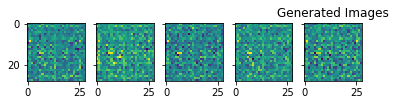

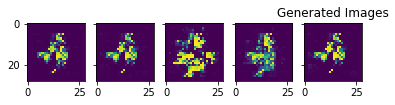

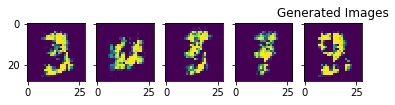

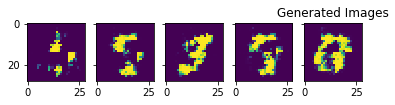

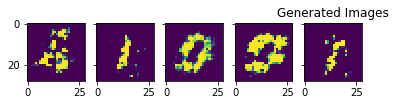

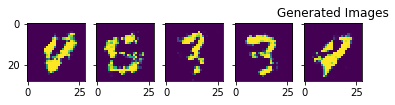

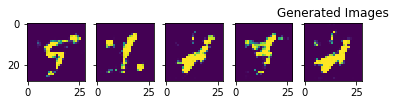

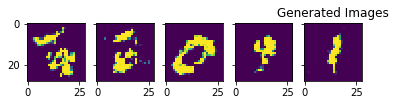

In [23]:
train_wGAN(n_iter=4000, batch_size=50, generator=generator, discriminator=discriminator, regularization = 10.)